In [1]:
import numpy as np
from pathlib import Path
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
import sys 
sys.path.append("../")

In [2]:
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
boxsize = 1000.
r_bins = np.linspace(0.5, 150.0, 25)
k_values = [1,5,9]
r_c = 0.5*(r_bins[1:] + r_bins[:-1])
mu_bins = np.linspace(-1, 1, 201)
n = 50 

data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/')
test_halos = np.load(data_dir / 'test_halos_fiducial.npy')[:n,:,:3]

In [6]:
def get_tpcf(pos,):
    return TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=pos.T,
                engine="corrfunc",
                n_threads=2,
                boxsize=boxsize,
                los="z",
    )(ells=[0])[0]

from cosmo_utils.knn import get_CDFkNN
def get_knn(pos,k_values=[1,5,9]):
    random_pos = np.random.uniform(0, boxsize, size=pos.shape)
    pos %= boxsize
    return get_CDFkNN(
        r_bins,
        pos,
        random_pos,
        boxsize=boxsize,
        k=k_values,
    )

In [7]:

run_name = 'gallant-cherry-87'
checkpoint = 225000 
path_to_samples = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/set_diffuser/samples/{run_name}')
generated_samples = np.load(path_to_samples / f'fiducial_samples_steps500_checkpoint{checkpoint}.npy')[:n]

In [8]:
# compute 2pcfs
test_tpcfs = []
for hpos in test_halos:
    test_tpcfs.append(
        get_tpcf(hpos)
    )
test_gen_tpcfs = []
for hpos in generated_samples:
    test_gen_tpcfs.append(get_tpcf(hpos))


In [9]:
# compute 2pcfs
test_knns = []
for hpos in test_halos:
    test_knns.append(
        get_knn(hpos, k_values=k_values)
    )

test_gen_knns = []
for hpos in generated_samples:
    test_gen_knns.append(
        get_knn(hpos, k_values=k_values)
    )
test_gen_knns = np.array(test_gen_knns)
test_knns = np.array(test_knns)

I0000 00:00:1700672942.724973 1212377 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2023-11-22 12:09:03.827295: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 84987740160
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


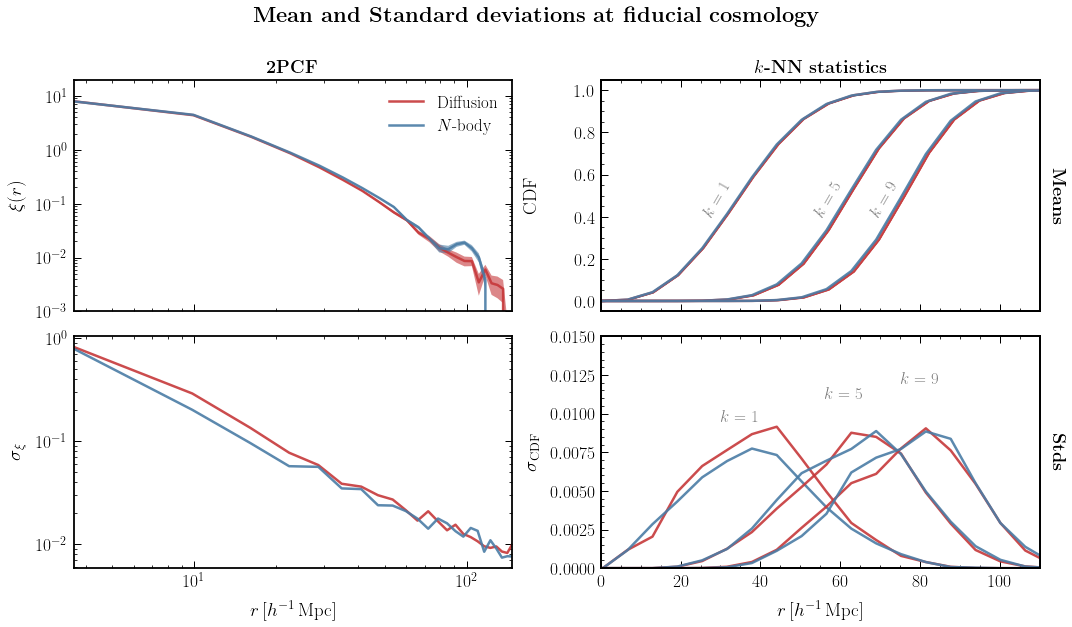

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,8.5), sharex='col',)
ax[0,0].fill_between(
    1.01*r_c, 
    (np.mean(test_gen_tpcfs,axis=0) -np.std(test_gen_tpcfs,axis=0)/np.sqrt(n)), 
    (np.mean(test_gen_tpcfs,axis=0) +np.std(test_gen_tpcfs,axis=0)/np.sqrt(n)), 
    alpha=0.6,
)
c_diff = ax[0,0].plot(
    1.01*r_c, 
    np.mean(test_gen_tpcfs,axis=0),
    label='Diffusion',
)

ax[0,0].fill_between(
    1.01*r_c, 
    (np.mean(test_tpcfs,axis=0) -np.std(test_tpcfs,axis=0)/np.sqrt(n)), 
    (np.mean(test_tpcfs,axis=0) +np.std(test_tpcfs,axis=0)/np.sqrt(n)), 
    alpha=0.6,
)
c_quijote = ax[0,0].plot(
    1.01*r_c, 
    np.mean(test_tpcfs,axis=0),
    label=r'$N$-body',
)
ax[0,0].legend()
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylim(1.e-3,20)
ax[0,0].set_xlim(r_c[0], r_c[-1])



k_idx_list = [0,1,2]
k_value = [1,5,9]
for k_idx in k_idx_list:


    ax[0,1].fill_between(
        1.01*r_bins, 
        np.mean(test_gen_knns[:,k_idx], axis=0) - np.std(test_gen_knns[:,k_idx], axis=0)/np.sqrt(n),
        np.mean(test_gen_knns[:,k_idx], axis=0) + np.std(test_gen_knns[:,k_idx], axis=0)/np.sqrt(n),
        alpha=0.6,
        color=c_diff[0].get_color(),
    )
    ax[0,1].plot(
        1.01*r_bins, 
        np.mean(test_gen_knns[:,k_idx], axis=0),
        label='Diffusion' if k_idx==0 else None, 
        color=c_diff[0].get_color(),
    )
    ax[0,1].fill_between(
        r_bins, 
        np.mean(test_knns[:,k_idx], axis=0) - np.std(test_knns[:,k_idx], axis=0)/np.sqrt(n),
        np.mean(test_knns[:,k_idx], axis=0) + np.std(test_knns[:,k_idx], axis=0)/np.sqrt(n),
        alpha=0.6,
        color=c_quijote[0].get_color(),
    )
    ax[0,1].plot(
        r_bins, 
        np.mean(test_knns[:,k_idx], axis=0),
        label='Quijote' if k_idx==0 else None, 
        color=c_quijote[0].get_color(),
    )



    ax[0,1].set_xlim(0,110)
ax[0,0].set_ylabel(r'$\xi(r)$')
ax[0,1].set_ylabel(r'CDF')
ax[0,1].text(25, 0.4, f'$k = {k_value[0]}$', rotation=60, fontsize=17,color='gray')
ax[0,1].text(53, 0.4, f'$k = {k_value[1]}$', rotation=60, fontsize=17,color='gray')
ax[0,1].text(67, 0.4, f'$k = {k_value[2]}$', rotation=60, fontsize=17,color='gray')

ax[1,0].loglog(
    r_c,
    np.std(test_gen_tpcfs,axis=0),
    label='Diffusion',
)
ax[1,0].loglog(
    r_c,
    np.std(test_tpcfs,axis=0),
    label='Quijote',
)

for k_idx in k_idx_list:
    ax[1,1].plot(
        r_bins,
        np.std(test_gen_knns[:,k_idx],axis=0),
        color=c_diff[0].get_color(),
    )
    ax[1,1].plot(
        r_bins,
        np.std(test_knns[:,k_idx],axis=0),
        color=c_quijote[0].get_color(),
    )

ax[1,0].set_ylabel(r'$\sigma_{\xi}$')
ax[1,0].set_xlabel(r"$r\,[h^{-1}\,{\rm Mpc}]$")

ax[1,1].set_ylabel(r'$\sigma_\mathrm{CDF}$')
ax[1,1].set_xlabel(r"$r\,[h^{-1}\,{\rm Mpc}]$")
ax[1,1].set_ylim(0.,0.015)
ax[1,1].text(30, 0.0095, f'$k = {k_value[0]}$', fontsize=17,color='gray')
ax[1,1].text(56, 0.011, f'$k = {k_value[1]}$', fontsize=17,color='gray')
ax[1,1].text(75, 0.012, f'$k = {k_value[2]}$', fontsize=17,color='gray')

ax[0,0].set_title(r"\bf{2PCF}", fontsize=18)
ax[0,1].set_title(r"\bf{$k$-NN statistics}", fontsize=18)
plt.suptitle(r"\bf{Mean and standard deviations at fiducial cosmology}", fontsize=22, y=1.02)

ax0_right = ax[0,1].twinx()
ax0_right.tick_params(axis="y", which="both", length=0)
ax0_right.set_yticks([])
ax0_right.set_ylabel(r'\bf{Means}', rotation=270, va='bottom', fontsize=18,)

ax1_right = ax[1,1].twinx()
ax1_right.tick_params(axis="y", which="both", length=0)
ax1_right.set_yticks([])
ax1_right.set_ylabel(r'\bf{Stds}', rotation=270, va='bottom', fontsize=18,)


plt.tight_layout()
fig.align_ylabels(axs=ax)
plt.savefig('plots/means_stds.pdf', bbox_inches='tight', )